In [1]:
import numpy as np
from qore import Mine, ASP, QAOA, VQE
from qore.utils import measure_operator, get_bitstring_probabilities

In [2]:
penalty = 15.0
qmine = Mine(np.array([[-2., 3., 1.], [float('inf'), 5., float('inf')]]))
qmine.plot_mine()

+---+--------+-------+-------+
|   |   0    |   1   |   2   |
+---+--------+-------+-------+
| 0 | -2.000 | 3.000 | 1.000 |
| 1 |  inf   | 5.000 |  inf  |
+---+--------+-------+-------+


In [3]:
qmine.graph

defaultdict(list, {3: [0, 1, 2], 0: [], 1: [], 2: []})

In [4]:
qmine.gen_Hamiltonian(penalty=penalty).to_opflow()

SummedOp([PauliOp(Pauli(z=[False, False, False, False], x=[False, False, False, False]), coeff=14.75), PauliOp(Pauli(z=[True, False, False, False], x=[False, False, False, False]), coeff=4.75), PauliOp(Pauli(z=[False, True, False, False], x=[False, False, False, False]), coeff=2.25), PauliOp(Pauli(z=[False, False, True, False], x=[False, False, False, False]), coeff=3.25), PauliOp(Pauli(z=[False, False, False, True], x=[False, False, False, False]), coeff=-13.75), PauliOp(Pauli(z=[True, False, False, True], x=[False, False, False, False]), coeff=-3.75), PauliOp(Pauli(z=[False, True, False, True], x=[False, False, False, False]), coeff=-3.75), PauliOp(Pauli(z=[False, False, True, True], x=[False, False, False, False]), coeff=-3.75)], coeff=1.0, abelian=False)

In [5]:
print(qmine.gen_Hamiltonian(penalty=penalty).to_opflow())

SummedOp([
  14.75 * IIII,
  4.75 * IIIZ,
  2.25 * IIZI,
  3.25 * IZII,
  -13.75 * ZIII,
  -3.75 * ZIIZ,
  -3.75 * ZIZI,
  -3.75 * ZZII
])


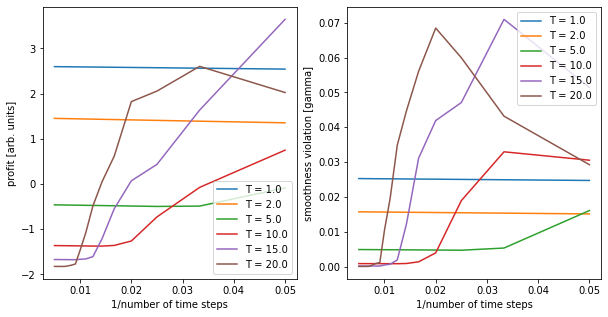

In [8]:
from qiskit.aqua import aqua_globals, QuantumInstance
from qiskit import Aer
import matplotlib.pyplot as plt

T_list  = [1.0, 2.0, 5.0, 10.0, 15.0, 20.0]
nt_list = [10 * x for x in range(2,21)] 
results = np.zeros((len(T_list), len(nt_list), 2))

for jT, T in enumerate(T_list):
    for jn, nt in enumerate(nt_list):

        aqua_globals.random_seed = 1953
        backend = Aer.get_backend('statevector_simulator')
        instance = QuantumInstance(backend=backend)

        circuit = ASP(qmine.gen_Hamiltonian(penalty=penalty), 
            evol_time=T, 
            nsteps=nt, 
            quantum_instance=instance).construct_circuit()

        # instead of looking at those awful "evolution" blocks, let us transpile the circuit
        circuit.decompose().draw()
        # from qiskit.compiler import transpile
        # circuit = transpile(circuit, backend, optimization_level=0)
        # if(jT == 0 and jn == 0):
        #     print(asp_circuit.draw())

        res_p = measure_operator(qmine.Hp, circuit, instance)
        res_s = measure_operator(qmine.Hs, circuit, instance)
        x = get_bitstring_probabilities(circuit, instance, shots=1024)

        results[jT, jn, 0] = res_p
        results[jT, jn, 1] = res_s / penalty

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

for jT, T in enumerate(T_list):
    axs[0].plot([1.0/float(x) for x in nt_list],
                results[jT, :, 0], label="T = "+str(T))
    axs[1].plot([1.0/float(x) for x in nt_list],
                results[jT, :, 1], label="T = "+str(T))

axs[0].set_ylabel('profit [arb. units]')
axs[1].set_ylabel('smoothness violation [gamma]')
axs[0].set_xlabel('1/number of time steps')
axs[1].set_xlabel('1/number of time steps')
axs[0].legend()
axs[1].legend()
plt.show()
